# Kernel Matrices   
$$X=\left(\begin{array}{c}
-x_{1}^T- \\
\vdots \\
-x_{n}^T- 
\end{array}\right)$$  

$$K=X X^T=\left[\begin{array}{c}
x_{1}^T \\
\vdots \\
x_{n}^T
\end{array}\right]\left[x_{1} \cdots x_{n}\right]$$  
$$=\left[\begin{array}{c}
x_{1}^T x_{1} \cdots x_{1}^{\top} x_{n} \\
x_{n}^{T} x_{1} \cdots \cdot x_{n}^{T} x_{n}
\end{array}\right]$$  
Therefore, we need to calculate the distance between any two vectors.  


# Kernel Ridge Regression   
(1)  
- Just calculate the derevative of $J(w)$, it is easy to get the result  
- Since $X^TX$ is psd, and $\lambda I$ is positive definite, then $X^TX + \lambda I$ is positively definited, then it is invertible (determinant is larger than 0).  
  
(2)
$\alpha = \frac{1}{\lambda} y -\frac{1}{\lambda}Xw$  

(3)  
$$\alpha = \left(\begin{array}{c}
\alpha_1 \\
\vdots \\
\alpha_n 
\end{array}\right)$$  
$$X^T = \left[x_{1} \cdots x_{n}\right]$$  
$$X^T\alpha = \sum_i^{n}\alpha_i x_i$$  
Hence, $w$ lies in the span space of $X$  

(4)  
$$\lambda \alpha = y - XX^T\alpha$$  
then we have  
$$\alpha = (\lambda I + XX^T)^{-1}y$$  

(5)  
$$Xw = XX^T\alpha = K\alpha$$  

(6)  
$$\begin{aligned}
f(x) &= x^Tw  \\
&= xX^T\alpha^*  \\
&= x[x_1 \cdots x_n]\alpha^*  \\
&=[x^Tx_1 \cdots x^Tx_n]\alpha^*  \\  
&=k_x^T\alpha^*
\end{aligned}$$

# [Optional] Pegasos and SSGD for $l_2$-regularized ERM  
(1)  
$g_i(w) = \lambda w + v_i(w)$  

(2)
$$
\begin{aligned}
\partial J_i(w) &= g_i(w)  \\  
\partial \frac{1}{n} \sum J_i(w) &= \frac{1}{n}\sum g_i(w) \quad (additivity)\\   
\partial J(w) &= \mathbb{E} g_i(w)
\end{aligned}
$$  

(3)  
Proof by deduction  
we first verify $w^{(2)}$ is correct  
$$
\begin{aligned}
w^{(2)} &= w^{(1)} - \eta^{(1)}g_i(w^{(1)}) \\  
&= 0 - \frac{1}{\lambda}g_i(w^{(0)})  \\ 
&= -\frac{1}{\lambda}v_i(w^{(0)})
\end{aligned}
$$  
suppose it is true at $k \in \mathbb{N}$, then  
$$
\begin{aligned}
w^{(k+1)} &= w^{(k)} - \eta^{(k)}g_i(w^{(k)}) \\  
&= w^{(k)} - \frac{1}{\lambda k}(\lambda w^{(k)} + v_i (w^{(k)}))\\  
&= (1 - \frac{1}{k})(-\frac{1}{\lambda (k-1)} \sum_{t = 1}^{k-1} v_i (w^{(t)}))\\  
&= -\frac{1}{\lambda k}\sum_{i=1}^{k - 1}v_i (w^{(t)}) -\frac{1}{\lambda k}v_i(w^{(k)})\\  
&= -\frac{1}{\lambda k}\sum_{t = 1}^k v_i(w^{(t)})
\end{aligned}
$$  


# Kernelized Pegasos
<div align="center"><img src = "./kernelized pegasos.jpg" width = '500' height = '100' align = center /></div>  

(1)  
$$
\begin{aligned}
y_jw_{t}^Tx_j &= y_j (\sum_{i=1}^n \alpha_i^{(t)}x_i)^Tx_j \\  
&= y_j (\sum_{i=1}^n \alpha_i^{(t)}k(x_i,x_j)) \\  
&= y_jK_j\alpha^{(t)}
\end{aligned}
$$  

(2)  
$$
\begin{aligned}
w^{(t+1)} &= (1 - \eta^{(t)}\lambda)w^{(t)}\\  
&= (1 - \frac{1}{t})w^{(t)}\\  
&= (1 - \frac{1}{t})\sum_{i = 1}^n\alpha_i^{(t)}x_i\\  
&= \sum_{i=1}^n (1 - \frac{1}{t})\alpha_i^{(t)}x_i
\end{aligned}
$$  
therefore  
$$
\alpha^{(t+1)} = (1 - \frac{1}{t})\alpha^{(t)}
$$  

(3)  
<div align="center"><img src = "./algorithm.jpg" width = '500' height = '100' align = center /></div>  

# Kernel Methods: Let's implement  
##  


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy.spatial
import functools

In [2]:
### Kernel function generators
def linear_kernel(X1, X2):
    """
    Computes the linear kernel between two sets of vectors.
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
    Returns:
        matrix of size n1xn2, with x1_i^T x2_j in position i,j
    """
    return np.dot(X1,np.transpose(X2))

In [3]:
# (1)
def RBF_kernel(X1,X2,sigma):
    """
    Computes the RBF kernel between two sets of vectors   
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        sigma - the bandwidth (i.e. standard deviation) for the RBF/Gaussian kernel
    Returns:
        matrix of size n1xn2, with exp(-||x1_i-x2_j||^2/(2 sigma^2)) in position i,j
    """
    kernel=np.exp(-scipy.spatial.distance.cdist(X1,X2,'sqeuclidean')/(2*sigma**2))
    return kernel


In [4]:
def polynomial_kernel(X1, X2, offset, degree):
    """
    Computes the inhomogeneous polynomial kernel between two sets of vectors
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        offset, degree - two parameters for the kernel
    Returns:
        matrix of size n1xn2, with (offset + <x1_i,x2_j>)^degree in position i,j
    """
    kernel=np.power((offset+np.dot(X1,np.transpose(X2))),degree)
    return kernel

In [5]:
input_data = np.array([-4,-1,0,2]).reshape(4,1)
linear_kernel(input_data, input_data)

array([[16,  4,  0, -8],
       [ 4,  1,  0, -2],
       [ 0,  0,  0,  0],
       [-8, -2,  0,  4]])

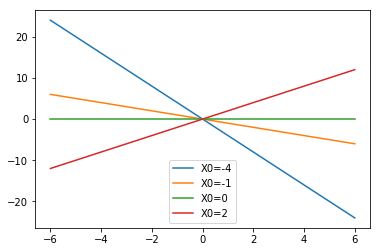

In [6]:
data = np.arange(-6,6.1,0.1)
x0 = [-4,-1,0,2]
for i in x0:
    kernel_matrix = [linear_kernel(i,x) for x in data]
    plt.plot(data,kernel_matrix,label='X0={}'.format(i))
plt.legend(loc='best')
plt.show()

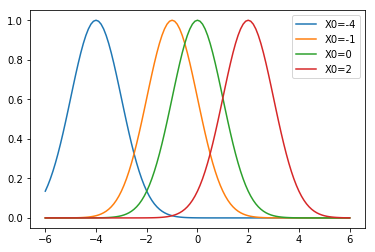

In [7]:
data=np.arange(-6,6.1,0.1)
x0=[-4,-1,0,2]
for i in x0:
    kernel_matrix=[RBF_kernel(np.array([i]).reshape(-1,1),np.array([x]).reshape(-1,1),1) for x in data]
    kernel_matrix=[x[0][0] for x in kernel_matrix]
    plt.plot(data,kernel_matrix,label='X0={}'.format(i))
plt.legend(loc='best')
plt.show()

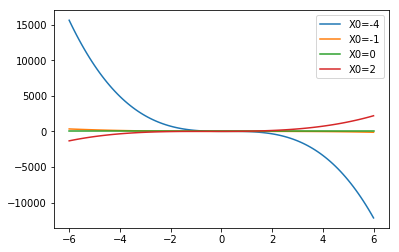

In [8]:
data=np.arange(-6,6.1,0.1)
x0=[-4,-1,0,2]
for i in x0:
    kernel_matrix=[polynomial_kernel(np.array([i]).reshape(-1,1),np.array([x]).reshape(-1,1),1,3) for x in data]
    kernel_matrix=[x[0][0] for x in kernel_matrix]
    plt.plot(data,kernel_matrix,label='X0={}'.format(i))
plt.legend(loc='best')
plt.show()

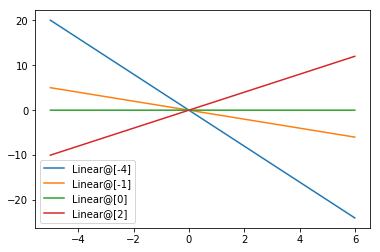

In [9]:
# PLot kernel machine functions

plot_step = .01
xpts = np.arange(-5.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)

# Linear kernel
y = linear_kernel(prototypes, xpts) 
for i in range(len(prototypes)):
    label = "Linear@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.show() 
 

In [5]:
class Kernel_Machine(object):
    def __init__(self, kernel, prototype_points, weights):
        """
        Args:
            kernel(X1,X2) - a function return the cross-kernel matrix between rows of X1 and rows of X2 for kernel k
            prototype_points - an Rxd matrix with rows mu_1,...,mu_R
            weights - a vector of length R with entries w_1,...,w_R
        """

        self.kernel = kernel
        self.prototype_points = prototype_points
        self.weights = weights
        
    def predict(self, X):
        """
        Evaluates the kernel machine on the points given by the rows of X
        Args:
            X - an nxd matrix with inputs x_1,...,x_n in the rows
        Returns:
            Vector of kernel machine evaluations on the n points in X.  Specifically, jth entry of return vector is
                Sum_{i=1}^R w_i k(x_j, mu_i)
        """
        return np.dot(self.kernel(X,self.prototype_points),self.weights)

In [6]:
from functools import partial
prototype_points = np.array([-1,0,1]).reshape(-1,1) 
weights = np.array([1,-1,1]).reshape(-1,1) 
x=np.array([-4,-1,0,2]).reshape(-1,1)
k_rbf=partial(RBF_kernel,sigma=1)
machine=Kernel_Machine(k_rbf,prototype_points,weights)
machine.predict(x)

array([[0.01077726],
       [0.52880462],
       [0.21306132],
       [0.48230437]])

In [7]:
xpt=np.arange(-6,6,0.01).reshape(-1,1)
result=[x[0] for x in machine.predict(xpt)]

Text(0.5, 1.0, 'RBF_KERNEL MACHINE')

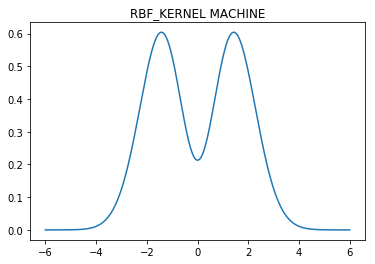

In [8]:
x_axis=np.arange(-6,6,0.01)
plt.plot(x_axis,result)
plt.title('RBF_KERNEL MACHINE')

In [9]:
data_train,data_test = np.loadtxt("krr-train.txt"),np.loadtxt("krr-test.txt")
x_train, y_train = data_train[:,0].reshape(-1,1),data_train[:,1].reshape(-1,1)
x_test, y_test = data_test[:,0].reshape(-1,1),data_test[:,1].reshape(-1,1)

Text(0, 0.5, 'y')

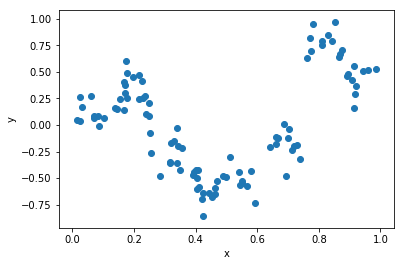

In [10]:
x=data_train[:,0]
y=data_train[:,1]
plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')

In [11]:
def train_kernel_ridge_regression(X, y, kernel, l2reg):
    #Aiming to calculate alpha
    #we get this formula from the previous homework
    #Essentially, this function is the "fit()" function in Class
    n=X.shape[0]
    alpha=np.linalg.inv(l2reg*np.identity(n)+kernel(X,X)).dot(y)
    
    return Kernel_Machine(kernel, X, alpha)

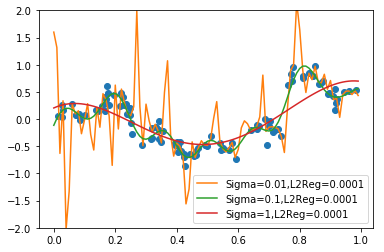

In [12]:
plot_step = .01
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
l2reg = 0.0001
for sigma in [0.01,0.1,1]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
    

plt.legend(loc = 'best')
plt.ylim(-2,2)
plt.show()

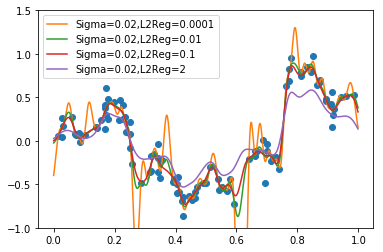

In [13]:
#Fix sigma and move l2reg
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
sigma= .02
for l2reg in [.0001,.01,.1,2]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

In [14]:
from sklearn.base import BaseEstimator, RegressorMixin

In [21]:
class myKernelRidgeRegression(BaseEstimator, RegressorMixin):
    def __init__(self, kernel = "RBF", sigma = 1, degree = 2, offset = 1, l2reg = 1):
        self.kernel = kernel
        self.sigma = sigma
        self.degree = degree
        self.offset = offset
        self.l2reg = l2reg
        
    def fit(self, X, y = None):
        if (self.kernel == "linear"):
            self.k = linear_kernel
        elif (self.kernel == "RBF"):
            self.k = partial(RBF_kernel, sigma = self.sigma)
        elif (self.kernel == "polynomial"):
            self.k = partial(polynomial_kernel, offset = self.offset, degree = self.degree)
        else:
            raise ValueError('Unrecognized Kernel type requested')
        self.machine = train_kernel_ridge_regression(X, y, self.k, self.l2reg)
        return self
    
    def predict(self, X, y = None):
        try:
            getattr(self, "machine")
        except AttributeError:
            raise RuntimeError('You have to train your data before predict')
        return self.machine.predict(X)
        

In [15]:
from sklearn.model_selection import GridSearchCV,PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error,make_scorer
import pandas as pd
    
test_fold = [-1]*len(x_train) + [0]*len(x_test)   #0 corresponds to test, -1 to train
predefined_split = PredefinedSplit(test_fold=test_fold)

In [22]:
param_grid = [{'kernel': ['RBF'],'sigma':[.1,1,10], 'l2reg': np.exp2(-np.arange(-5,5,1))},
              {'kernel':['polynomial'],'offset':[-1,0,1], 'degree':[2,3,4],'l2reg':[10, .1, .01] },
              {'kernel':['linear'],'l2reg': [10,1,.01]}]
kernel_ridge_regression_estimator = myKernelRidgeRegression()
grid = GridSearchCV(kernel_ridge_regression_estimator, 
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(mean_squared_error,greater_is_better = False)
                  # n_jobs = -1  #should allow parallelism, but crashes Python on my machine
                   )
grid.fit(np.vstack((x_train,x_test)),np.vstack((y_train,y_test))) 

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
       error_score='raise-deprecating',
       estimator=myKernelRidgeRegression(degree=2, kernel='RBF', l2reg=1, offset=1, sigma=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kernel': ['RBF'], 'sigma': [0.1, 1, 10], 'l2reg': array([32.    , 16.    ,  8.    ,  4.    ,  2.    ,  1.    ,  0.5   ,
        0.25  ,  0.125 ,  0.0625])}, {'kernel': ['polynomial'], 'offset': [-1, 0, 1], 'degree': [2, 3, 4], 'l2reg': [10, 0.1, 0.01]}, {'kernel': ['linear'], 'l2reg': [10, 1, 0.01]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)

In [23]:
pd.set_option('display.max_rows', 20)
df = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ["param_degree", "param_kernel","param_l2reg" ,"param_offset","param_sigma",
        "mean_test_score","mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow.sort_values(by=["mean_test_score"])

C:\Users\naive\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\naive\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\naive\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
27,-,RBF,0.0625,-,0.1,0.021270,0.023245
24,-,RBF,0.1250,-,0.1,0.022885,0.024608
21,-,RBF,0.2500,-,0.1,0.024845,0.026226
18,-,RBF,0.5000,-,0.1,0.026609,0.028110
15,-,RBF,1.0000,-,0.1,0.027562,0.030319
12,-,RBF,2.0000,-,0.1,0.028041,0.033539
9,-,RBF,4.0000,-,0.1,0.030082,0.039685
6,-,RBF,8.0000,-,0.1,0.037650,0.052373
54,4,polynomial,0.0100,-1,-,0.043454,0.060135
3,-,RBF,16.0000,-,0.1,0.055006,0.075591


In [ ]:
# Load and plot the SVM data
#load the training and test sets
data_train,data_test = np.loadtxt("svm-train.txt"),np.loadtxt("svm-test.txt")
x_train, y_train = data_train[:,0:2], data_train[:,2].reshape(-1,1)
x_test, y_test = data_test[:,0:2], data_test[:,2].reshape(-1,1)

#determine predictions for the training set
yplus = np.ma.masked_where(y_train[:,0]<=0, y_train[:,0])
xplus = x_train[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_train[:,0]>0, y_train[:,0])
xminus = x_train[~np.array(yminus.mask)]

#plot the predictions for the training set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 

pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='r', label = '+1 labels for training set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 labels for training set')

ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('Training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

In [ ]:
# Code to help plot the decision regions
# (Note: This ode isn't necessarily entirely appropriate for the questions asked. So think about what you are doing.)
 
sigma=1
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_soft_svm(x_train, y_train, k, ...)

#determine the decision regions for the predictions
x1_min = min(x_test[:,0])
x1_max= max(x_test[:,0])
x2_min = min(x_test[:,1])
x2_max= max(x_test[:,1])
h=0.1
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),
                     np.arange(x2_min, x2_max, h))

Z = f.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#determine the predictions for the test set
y_bar = f.predict (x_test) 
yplus = np.ma.masked_where(y_bar<=0, y_bar)
xplus = x_test[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_bar>0, y_bar)
xminus = x_test[~np.array(yminus.mask)]

#plot the learned boundary and the predictions for the test set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 
decision =ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='b', label = '+1 prediction for test set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 prediction for test set')
ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('SVM with RBF Kernel: training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

# Representer Theorem  
(1)  
Since  
$$\|x\|^{2}=\left\|m_{0}\right\|^{2}+\left\|x-m_{0}\right\|^{2}$$  
and 
$$\|m_0\| = \|x\|$$  
$$\|x-m_0\|^2 = \langle x-m_0,x-m_0\rangle \geq 0 \text{, and }\quad \langle x-m_0,x-m_0 \rangle = 0  $$  
then  
$$x-m_0 = 0 \quad \Rightarrow x = m_0$$  


(2)  
**proof**  
We consider if $w^*$ does not lie in the span space of $\{\psi(x_i)\}$, then its projection on that span space is also a minimizer, and we therefore get contradiction  
Let $w^*$ be the minimizer, and $M = span(\psi(x_1),..,\psi(x_n))$ --- the span of data. Let $w = Proj_Mw^*$, so $\exists w = \sum_{i = 1}^n \alpha_i \psi(x_i)$, then $$w^{\perp}:=w^{*}-w$$ is orthogonal to $M$.  
Projections decrease norms, then $\|w\| \leqslant \|w^*\|$, and since $R$ is strict increasing, we have $R(\|w\|) \leqslant R(\|w^*\|)$, if $\|w\| = \|w^*\|$, then $w^* = w$, and $w^*$ also lies in the span space; if $\|w\| < \|w^*\|$, then $J(w) < J(w^*)$, which means $w$ is the minimizer, and it lies in the span space   
and we have $\left\langle w^{*}, \psi\left(x_{i}\right)\right\rangle=\left\langle w+w^{\perp}, \psi\left(x_{i}\right)\right\rangle=\left\langle w, \psi\left(x_{i}\right)\right\rangle$  

# Ivanov and Tikhonov Regularization  
## Tikhonov optimal implies Ivanov optimal 

**proof**  
let $f^*$ be the solution of Tikhonov, let $r = \Omega(f^*)$, we want to show $f^*$ is also the solution of Ivanov form. Suppose it is not, i.e. there exists $f'$, that is Ivanov optimal. Then we have $\phi(f') < \phi(f^*)$, and $\Omega(f') \leq r =\Omega(f^*)$, then $\phi(f') + \lambda\Omega(f') < \phi(f^*) + \lambda \Omega(f^*)$, which contradicts that $f^*$ is the optimal of Tikhonov form.

## [Optional] Ivanov optimal implies Tikhonov optimal (when we have Strong Duality) 

(1)  
$$L(w,\lambda) = \phi(w) + \lambda(\Omega(w) - r)$$  
(2)  
- Then we can write the primal and dual form  
$$\begin{aligned}
p^{*} &=\inf _{w\in R^d} \sup _{\lambda\geq  0} L(w, \lambda) \\
& \geqslant \sup _{ \lambda \geq 0} \inf _{w\in R^d} L(w,\lambda)=d^{*}
\end{aligned}$$  
$$g(\lambda) = \inf_{w\in R^d}L(w,\lambda)$$

(3)  
Strong duality inplies complementary slackness:  
$$\lambda^*(\Omega(w^*) - r) = 0$$  
we have  
$$\phi(w^*) = \sup_{\lambda \geq 0}L(w^*, \lambda) = g(\lambda^*) = \inf_{w\in R^d}L(w, \lambda^*)$$

# Positive Semidefinite Matrix

(1)  
$$M = Q\Sigma Q^T$$  
since $M$ is psd, for any $x\in R^d$  
$$(Q^Tx)^T\Sigma(Q^Tx) \geq 0$$  
since $Q^Tx \in R^d$, $\Sigma$ is psd,  
then the eigenvalues of $M$ is all non-negative

(2)  
First we proof $M = BB^T \qquad \Rightarrow M$ is psd  
choose any $x \in R^d$, $x^TBB^Tx = (B^Tx)^TB^Tx \geq 0$, since $B^T x \in R^d$  
then we proof $M$ is psd implies $M=BB^T$  
let $B = Q\sqrt{\Sigma}$, where $\sqrt{\Sigma}$ means elementwise square root

# Positive Definite Matrix

(2)  
Since $Q$ is orthogonal, $Q^T = Q^{-1}$, it is easy to show the result  
(3)  
$$x^T(X+\lambda I)x =x^TMx+\lambda x^TIx > 0$$

(4)  
For any $x \ne 0$, if $x \in \text{ Null}(M + N)$, then $x^T(M+N)x= x^T 0 =0$,which contradicts the assumption, thus $\text{Null}(M+N) = \emptyset $, thus $M + N$ is invertible 